# Internal Functions

When debugging issues or testing configurations, it may be advantagous to run Isofit in a more controlled manner than the end-to-end Apply OE pipeline. This notebook gives a quick introduction to the structure of Isofit and how it can be used more like a Python package.

NOTE: Isofit is actively developed, so while we try to make sure that Apply OE is stable from a CLI standpoint, individual functions are subject to change.

We'll start with the medium example found at `~/.isofit/imagecube/medium`. First, run Apply OE on this example, or for more adept users, run Apply OE with the `--config_only` flag. The objective here, is to generate an Isofit config file at `~/.isofit/imagecube/small/config/ang20170323t202244_isofit.json`. This saves us the trouble of building the configuration file manually. We can edit the Apply OE generated configuration as needed.

In [7]:
# Imports
from pathlib import Path
from pprint import pprint

from matplotlib import pyplot as plt
import numpy as np
from spectral import envi

from isofit.core.common import envi_header
from isofit.core.isofit import Isofit
from isofit.configs import configs
from isofit.core.forward import ForwardModel
from isofit.radiative_transfer.radiative_transfer import RadiativeTransfer
from isofit.surface.surface import Surface
from isofit.core.instrument import Instrument
from isofit.inversion.inverse import Inversion
from isofit.core.geometry import Geometry
from isofit.core.fileio import IO
from isofit.inversion.inverse_simple import (
    invert_algebraic,
    invert_analytical,
    invert_simple,
)

In [2]:
# Load the input data
rdn_path = Path('~/.isofit/imagecube/medium/ang20170323t202244_rdn_7k-8k')
loc_path = Path('~/.isofit/imagecube/medium/ang20170323t202244_loc_7k-8k')
obs_path = Path('~/.isofit/imagecube/medium/ang20170323t202244_obs_7k-8k')

rdn = envi.open(envi_header(str(rdn_path.expanduser())))
loc = envi.open(envi_header(str(loc_path.expanduser())))
obs = envi.open(envi_header(str(obs_path.expanduser())))

rdn_im = rdn.open_memmap(interleave='bip')
loc_im = loc.open_memmap(interleave='bip')
obs_im = obs.open_memmap(interleave='bip')

wl = np.array(rdn.metadata['wavelength']).astype(float)

### ISOFIT Configs and Classes

ISOFIT is built around object classes.

For example, the `config` object contains the full Isofit config. This is constructed directly from the config `.json` file via the `configs.create_new_config` function. 

In [15]:
# Initialize the config object
config_file = Path('~/.isofit/imagecube/medium/config/ang20170323t202244_isofit.json')
config =  configs.create_new_config(str(config_file.expanduser()))

print('The config object:')
print(config)
print()

print('Config attributes:')
[print(key) for key in vars(config).keys()]
print()

print('Example:')
print(f'Forward model type: {config._forward_model_type}')
print(f'Forward model: {config.forward_model}\n')

print('Forward model:')
pprint(vars(config.forward_model), width=100, compact=False)
print()
print('Surface model:')
pprint(vars(config.forward_model.surface), width=100, compact=False)

The config object:

Config attributes:
_input_type
input
_output_type
output
_forward_model_type
forward_model
_implementation_type
implementation

Example:
Forward model type: <class 'isofit.configs.sections.forward_model_config.ForwardModelConfig'>
Forward model: <isofit.configs.sections.forward_model_config.ForwardModelConfig object at 0x15da2d8d0>

Forward model:
{'_instrument_type': <class 'isofit.configs.sections.instrument_config.InstrumentConfig'>,
 '_model_discrepancy_file_type': <class 'str'>,
 '_radiative_transfer_type': <class 'isofit.configs.sections.radiative_transfer_config.RadiativeTransferConfig'>,
 '_surface_type': <class 'isofit.configs.sections.surface_config.SurfaceConfig'>,
 'instrument': <isofit.configs.sections.instrument_config.InstrumentConfig object at 0x15da2cfa0>,
 'model_discrepancy_file': None,
 'radiative_transfer': <isofit.configs.sections.radiative_transfer_config.RadiativeTransferConfig object at 0x15da2d930>,
 'surface': <isofit.configs.sections.surf

The `ForwardModel` object contains the `Instrument`, `Radiative transfer` and `Surface` portions of the ISOFIT forward model. The three forward model components are object classes themselves, which contain the math and logic relevant to these features. For example, the `Instrument` portion holds functions for instrument uncertainty quantification and calibration, the `Radiative transfer` portion holds functions relevant for generating and sampling the radiative transfer lookup-tables (LUTs), and the `Surface` portion holds functions relevant to sampling surface priors and formulating surface-specific forward model elements.

Note: if the LUT has not been generated at the expected location from the config, initializing the forward model class will immediately constructing the LUT at that location.

In [18]:
print('The expected location of the LUT:')
print(config.forward_model.radiative_transfer.radiative_transfer_engines[0].lut_path)
print()

# Initialized from the config:
fm = ForwardModel(config)

# Print the three forward model components
print(fm.instrument)
print(fm.RT)
print(fm.surface)

# Print an example method from RT
print(fm.RT.calc_rdn)

The expected location of the LUT:
/Users/bgreenbe/.isofit/imagecube/medium/lut_full/lut.nc

<bound method RadiativeTransfer.calc_rdn of <isofit.radiative_transfer.radiative_transfer.RadiativeTransfer object at 0x118544700>>


and individual component classes can also be initialized from the `config` object:

In [19]:
instrument = Instrument(config)
rt = RadiativeTransfer(config)
surface = Surface(config)

The optimal estimation inversion is handled by the Inversion class object.

### OE Inversions

We will go into how to perform single pixel optimal estimation (OE) inversions from a set of input data and an ISOFIT config. To do this, we need to load in a radiance spectrum with paired observational geometry data. We'll pull this directly from the `rdn`, `obs`, and `loc` files we loaded above. 

OE inversions are run using the Inversion class:

In [20]:
iv = Inversion(config, fm)

Next, we'll select a pixel to run through the OE inversion.

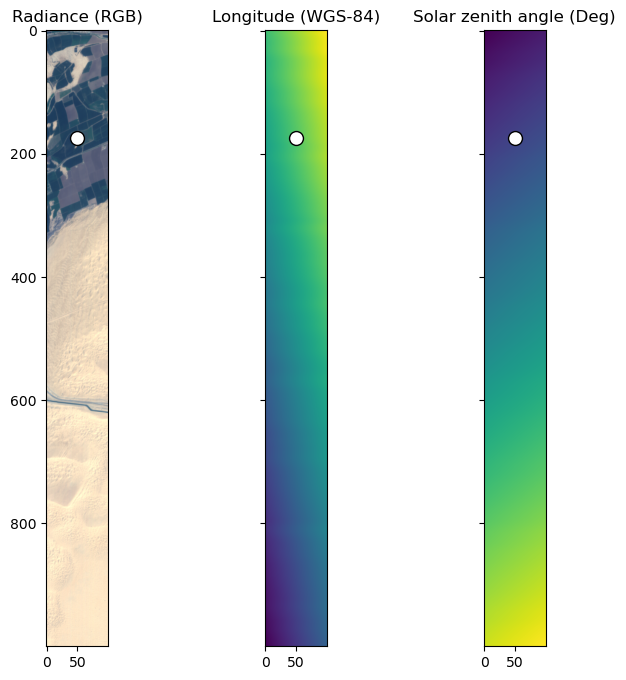

In [21]:
# Pick a pixel
row = 175
col = 50

# Plot the input data
normalize = lambda x, vmin, vmax:  (x - vmin) / (vmax - vmin)
bands = [55, 35, 15]

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 8))
plot = axs[0].imshow(normalize(rdn_im[..., bands], 0, 15))
plot = axs[1].imshow(loc_im[..., 0])
plot = axs[2].imshow(obs_im[..., 4])

axs[0].scatter(col, row, facecolor='white', edgecolor='black', s=100)
axs[1].scatter(col, row, facecolor='white', edgecolor='black', s=100)
axs[2].scatter(col, row, facecolor='white', edgecolor='black', s=100)

title = axs[0].set_title('Radiance (RGB)')
title = axs[1].set_title('Longitude (WGS-84)')
title = axs[2].set_title('Solar zenith angle (Deg)')

Then we'll load in the measurement and observational data for that pixel. The geometry object holds all of the observational information for a given pixel.

In [27]:
meas = rdn_im[row, col, :]
geom = Geometry(
    obs=obs_im[row, col, :],
    loc=loc_im[row, col, :],
    esd=IO.load_esd(),
    svf=1
)

# e.g.
print(geom.solar_azimuth)
print(geom.observer_azimuth)
print(geom.cos_i)

197.31315008280822
71.53144734704047
-0.3017277626279998


and finally run the OE inversion via the inversions.invert function:

In [28]:
oe = iv.invert(meas, geom)

print(f"Number of iterations to convergence: {len(oe)}")
print(f"Data type of 'oe': {type(oe)}")
print(f"Array shape: {oe.shape}")

Number of iterations to convergence: 9
Data type of 'oe': <class 'numpy.ndarray'>
Array shape: (9, 427)


The `oe` variable is a numpy array where each row is a subsequent iteration of the OE procedure. It is often useful to examine how the solution changes during optimization, which can help debug potential issues with final statevector solutions.

The plots below show the trajectory of the reflectance solution throughout the optimization. The earlier solutions are lighter colors while the later solutions are darker colors.

The plots also show the prior mean selected for this specific pixel via the `surface.xa` function, which can be called directly using the initial guess of the reflectance solution and the pixel observation variables.

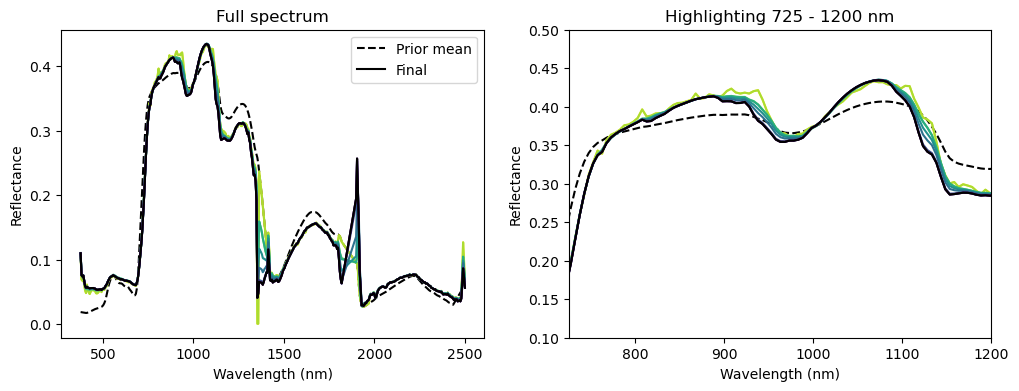

In [30]:
# Set up a color map for the iterations
n = len(oe)
cmap_name = 'viridis_r'
cmap = plt.get_cmap(cmap_name)
colors = [cmap(i) for i in np.linspace(0, 1, n)]

# Fit the prior mean
xa = fm.surface.xa(oe[0], geom)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(wl, xa[:len(wl)], color='black', ls='--', label='Prior mean')
axs[1].plot(wl, xa[:len(wl)], color='black', ls='--')
for i, sp in enumerate(oe):
    axs[0].plot(wl, sp[:len(wl)], color=colors[i])
    axs[1].plot(wl, sp[:len(wl)], color=colors[i])

axs[0].plot(wl, oe[-1][:len(wl)], color='black', label='Final')
axs[1].plot(wl, oe[-1][:len(wl)], color='black')

axs[0].set_ylabel('Reflectance')
axs[0].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Reflectance')
axs[1].set_xlabel('Wavelength (nm)')

axs[1].set_xlim([725, 1200])
axs[1].set_ylim([.1, .5])

axs[0].set_title('Full spectrum')
axs[1].set_title('Highlighting 725 - 1200 nm')

axs[0].legend()

plt.show()

We can also look at the trajectory of atmospheric statevector variables:

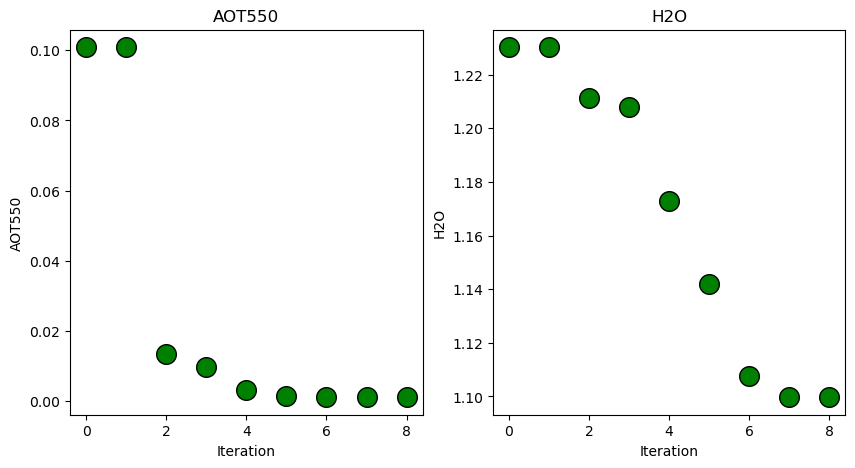

In [31]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
iters = [i for i in range(len(oe))]
axs[0].set_title('AOT550')
axs[0].scatter(iters, oe[:, -2], edgecolor='black', facecolor='green', s=200)
axs[0].set_ylabel('AOT550')

axs[1].set_title('H2O')
axs[1].scatter(iters, oe[:, -1], edgecolor='black', facecolor='green', s=200)
axs[1].set_ylabel('H2O')

axs[0].set_xlabel('Iteration')
axs[1].set_xlabel('Iteration')
plt.show()

### Inversions with a constrained atmosphere

Scene-scale processing generally leverages superpixel algorithms that simultaneously speed up processing and enforce a spatially smooth atmosphere. Here, we'll demonstrate the analytical line algorithm. The analytical line algorithm assumes there exists a closed form state-vector solution under the assumptions of 1) a fixed atmosphere, and 2) that the measurement can be modeled as a linear combination of state-vector elements. We can call the anlaytical line solution for a given pixel directly, albeit with slightly more set-up.

First, we'll set up a wrapper function to call the analytical line inversion. In practice, the analytical inversion is sensitive to the initial guess (x0 below). We generally use the "priorless" solution for the state-vector elemnents for a given atmosphere via the `invert_algebraic` and `iv.fm.surface.fit_params` functions.

In [32]:
def invert_aoe(iv, meas, geom, sub_state, x_RT, n=1):

    # This script sets up the initial guess for the inversion
    x_surface, _, x_instrument = iv.fm.unpack(iv.fm.init.copy())
    rfl_est, coeffs = invert_algebraic(
        iv.fm.surface,
        iv.fm.RT,
        iv.fm.instrument,
        x_surface,
        x_RT,
        x_instrument,
        meas,
        geom,
    )

    rfl_est = iv.fm.surface.fit_params(rfl_est, geom)

    x0 = np.concatenate(
        [
            rfl_est,
            x_RT,
            x_instrument,
        ]
    )

    # This script is responsible for performing the inversion
    states, unc, EXIT_CODE = invert_analytical(
        iv.fm,
        iv.winidx,
        meas,
        geom,
        np.copy(x0),
        sub_state,
        n,
        None,
        None,
    )

    return states[-1], unc, x0

Next, we will pull the superpixel state solution and spatially smooth atmosphere for the selected pixel. 

Note: This assumes that these files already exist at the expected location.

In [34]:
sub_state_path = Path('~/.isofit/imagecube/medium/output/ang20170323t202244_subs_state')
lbl_path = Path('~/.isofit/imagecube/medium/output/ang20170323t202244_lbl')
atm_path = Path('~/.isofit/imagecube/medium/output/ang20170323t202244_atm_interp')

sub_state = envi.open(envi_header(str(sub_state_path.expanduser())))
lbl  = envi.open(envi_header(str(lbl_path.expanduser())))
atm = envi.open(envi_header(str(atm_path.expanduser())))

sub_state_im = sub_state.open_memmap(interleave='bip')
lbl_im = lbl.open_memmap(interleave='bip')
atm_im = atm.open_memmap(interleave='bip')

idx = int(lbl[row, col, 0])
sub_state = sub_state_im[idx, 0, :]
x_RT = atm_im[row, col, :]

We can then call the wrapper function. Solutions are generally acceptible after one iteration, but `n` can be definted to explictely set the number of iterations to perform. 

In [35]:
aoe, aoe_unc, x0 = invert_aoe(
    iv, meas, geom, sub_state, x_RT, n=1
)

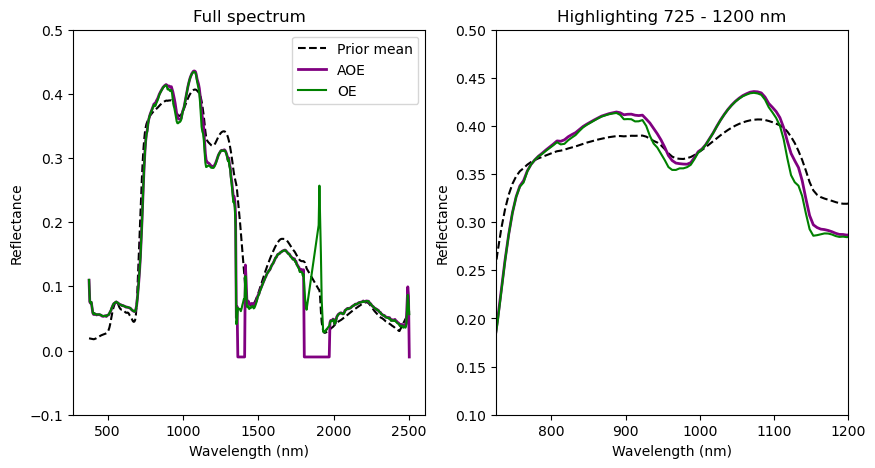

In [37]:
# Set up a color map for the iterations
n = len(oe)
cmap_name = 'viridis_r'
cmap = plt.get_cmap(cmap_name)
colors = [cmap(i) for i in np.linspace(0, 1, n)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(wl, xa[:len(wl)], color='black', ls='--', label='Prior mean')
axs[1].plot(wl, xa[:len(wl)], color='black', ls='--')

axs[0].plot(wl, aoe[:len(wl)], color='purple', lw=2, label='AOE')
axs[1].plot(wl, aoe[:len(wl)], color='purple', lw=2)

axs[0].plot(wl, oe[-1][:len(wl)], color='green', label='OE')
axs[1].plot(wl, oe[-1][:len(wl)], color='green')

axs[0].set_ylabel('Reflectance')
axs[0].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Reflectance')
axs[1].set_xlabel('Wavelength (nm)')

axs[1].set_xlim([725, 1200])
axs[1].set_ylim([.1, .5])
axs[0].set_ylim([-.1, .5])

axs[0].set_title('Full spectrum')
axs[1].set_title('Highlighting 725 - 1200 nm')

axs[0].legend()

plt.show()

In [111]:
### Algebraic inversions